# Evaluating changes in assessed property value in Monadnock Region municipalities

In [1]:
import pandas as pd
import re
# from simpledbf import Dbf5 # For reading shapefile

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
%matplotlib notebook

## Read and Clean 2009 data

Property tax data sourced from the [NH Dept. of Revenue Administration](https://www.revenue.nh.gov/mun-prop/municipal/documents/2009-local.pdf). I exported the PDF to a csv file. Some cleanup of the file was necessary.

## Get NH total changes

For comparison purposes.

In [4]:
def clean_int(x):
    
    x = str(x)
    x = x.replace(',','')
    x = x.replace('*','')
    x = x.replace('$','')
    x = x.strip()
    x = re.search('([0-9]*)', x)[0]        
   
    try:
        return int(x)
    except:
        return -999

In [21]:
df_2009 = pd.read_excel('../../Data/Property Tax/property_tax_rates_2009.xlsx')
df_2009 = df_2009[['Name of\nMunicipality','Town Valuation']]
df_2009.columns = ['Name','Valuation']
df_2009.Valuation = df_2009['Valuation'].apply(clean_int)

In [22]:
df_2009.columns = ['Name','VAL_2009']

Adjust for inflation. `$1.00 (2010) = $1.18 (2019)`, according the [U.S. Bureau of Labor Statistics](https://data.bls.gov/cgi-bin/cpicalc.pl).

In [5]:
# df_2009.VAL_2009 = (df_2009.VAL_2009 * 1.18).astype('int')

In [23]:
df_2009.head()

,Name,VAL_2009
0,ACWORTH,101804235
1,ALBANY,108574159
2,ALEXANDRIA,238425100
3,ALLENSTOWN,266789172
4,ALSTEAD,169439370


## Read and Clean 2018 Data

In [5]:
df_2018 = pd.read_csv('../../Data/Property Tax/property_tax_rates_2019.csv')
df_2018 = df_2018[['Municipality','Valuation w/ Utils']]
df_2018.columns=['Name', 'VAL_2018']
df_2018.VAL_2018 = df_2018.VAL_2018.apply(clean_int)
df_2018.Name = df_2018.Name.str.upper()

df_2018['Name'] = df_2018['Name'].str.replace(' \(U\)','')

In [18]:
df_2019  = df_2018[df_2018.Name.isin(swrpc.TOWN)]

In [20]:
df_2019.VAL_2018.sum()

9575491376

In [21]:
df_2019

,Name,VAL_2018
4,ALSTEAD,163042993
8,ANTRIM,248536250
21,BENNINGTON,126552077
44,CHESTERFIELD,520186333
66,DUBLIN,271767340
82,FITZWILLIAM,292489940
90,GILSUM,70802123
96,GREENFIELD,168431827
99,GREENVILLE,116267381
106,HANCOCK,249978341


## Merge the 2 dataframes

In [24]:
df = df_2009.merge(df_2018,left_on='Name',right_on='Name',how='outer')
df[df.isnull().any(axis=1)].sort_values(by='Name')
df = df.set_index('Name')
df = df.drop(["LOW & BURBANK'S GRANT",'PENACOOK']) # Not included in 2009 data. Only $1 assessed value in 2018.

In [25]:
df.loc['NH'] = df.sum()

In [26]:
df['PCT_CHANGE'] = df.VAL_2018 / df.VAL_2009  - 1

In [28]:
df.loc['PETERBOROUGH']

VAL_2009      6.968479e+08
VAL_2018      7.023140e+08
PCT_CHANGE    7.844138e-03
Name: PETERBOROUGH, dtype: float64

## Filter for SWRPC municipalities

In [7]:
swrpc = pd.read_csv('https://raw.githubusercontent.com/toddhorner/swrpc_data/master/Utility%20Datasets/SWRPC_munis.csv')
swrpc.TOWN = swrpc.TOWN.str.strip().str.upper()

In [52]:
swrpc = df[df.index.isin(swrpc.TOWN) | (df.index == 'NH')]

In [53]:
swrpc = swrpc.sort_values(by='PCT_CHANGE',ascending=False)
swrpc = swrpc.reset_index()

In [54]:
swrpc

,Name,VAL_2009,VAL_2018,PCT_CHANGE
0,NH,1.649887e+11,1.742986e+11,0.056428
1,HINSDALE,3.280790e+08,3.458897e+08,0.054288
2,NELSON,1.207688e+08,1.225141e+08,0.014452
3,WINDSOR,2.776435e+07,2.801775e+07,0.009127
4,WALPOLE,4.439020e+08,4.478341e+08,0.008858
5,PETERBOROUGH,6.968479e+08,7.023140e+08,0.007844
6,ANTRIM,2.462237e+08,2.476877e+08,0.005946
7,TROY,1.301866e+08,1.301517e+08,-0.000269
8,SURRY,8.106297e+07,8.076718e+07,-0.003649
9,RICHMOND,1.026227e+08,1.005994e+08,-0.019716


## Visualize data

In [75]:
test = swrpc[swrpc.Name.isin(['NH','RICHMOND'])].reset_index(drop=True)

In [76]:
test

,Name,VAL_2009,VAL_2018,PCT_CHANGE
0,NH,1.649887e+11,1.742986e+11,0.056428
1,RICHMOND,1.026227e+08,1.005994e+08,-0.019716


In [79]:
plt.style.use('seaborn-white')
mpl.rcParams['font.sans-serif'] = "Oswald"
mpl.rcParams['font.family'] = "sans-serif"
colors = ['#F15A5A', '#4EBA6F']
sns.set_palette(sns.color_palette(colors))

sns.set_context('notebook', rc={"lines.linewidth": 2.5})

In [86]:
test = test.iloc[::-1].reset_index(drop=True)

In [241]:
test

,Name,VAL_2009,VAL_2018,PCT_CHANGE
0,RICHMOND,1.026227e+08,1.005994e+08,-0.019716
1,NH,1.649887e+11,1.742986e+11,0.056428


/Users/toddhorner/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


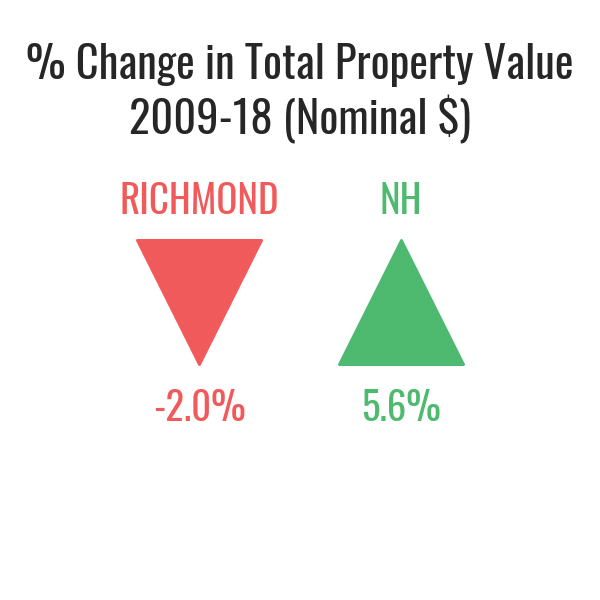

In [243]:
def graph_df(df):
    fig, ax = plt.subplots(figsize=(3,3))
    for index, row in df.iterrows():
        if row.PCT_CHANGE < 0:
            marker = 'v'
        else:
            marker = '^'
        plt.scatter(index, 0, color=colors[index],marker=marker,s=2000)
        
        # Set town label
        plt.text(index, 0.035, row.Name, color=colors[index],horizontalalignment='center',fontsize=14)
        
        #Set pct change label
        pct_change = '{:.1%}'.format(row.PCT_CHANGE)
        plt.text(index, -0.035, pct_change,
                 color=colors[index],
                 fontsize=14,
                 verticalalignment='top',
                 horizontalalignment='center')
    plt.ylim([-.1,.1])
    plt.xlim([-.6,1.6])

    [ax.spines[spine].set_visible(False) for spine in ax.spines]
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,
        left=False, # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    plt.title('% Change in Total Property Value\n2009-18 (Nominal $)',y=.8, fontsize=16)
    plt.tight_layout()
    plt.savefig('../../Exported Graphics/Property Value/{}_prop_value.png'.format(df.loc[0,'Name']))

graph_df(test)

In [239]:
ls ../../Exported\ Graphics

Broadband/                       Miscellaneous/
Economic Development/            Percent Working at Home/
High Schoolers Entering College/


<IPython.core.display.Javascript object>


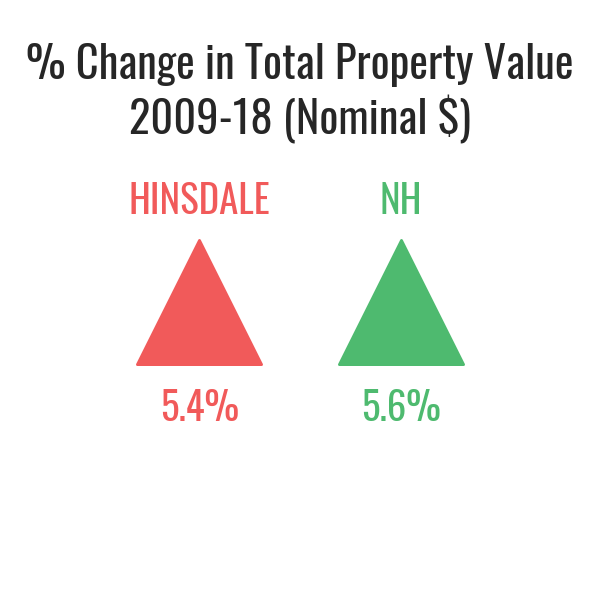

<IPython.core.display.Javascript object>


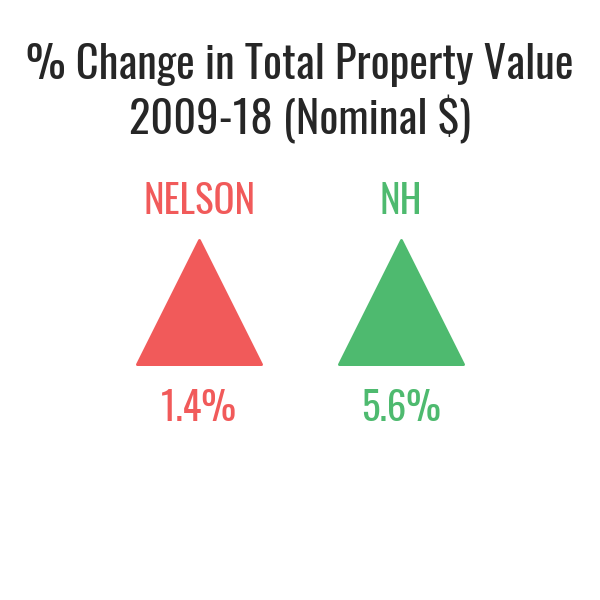

<IPython.core.display.Javascript object>


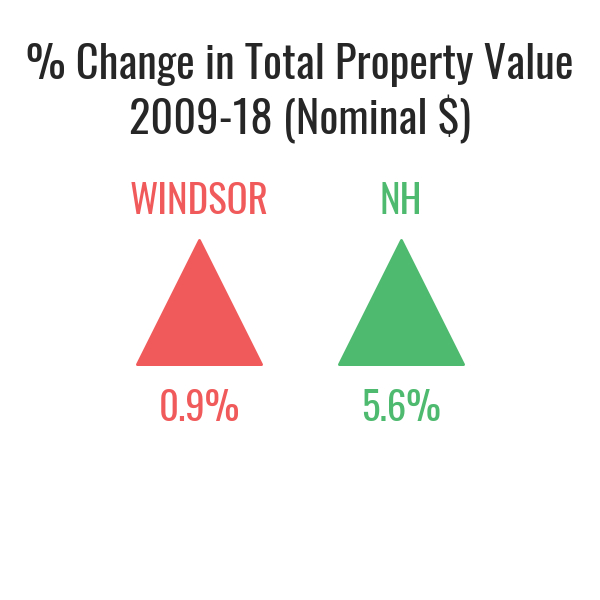

<IPython.core.display.Javascript object>


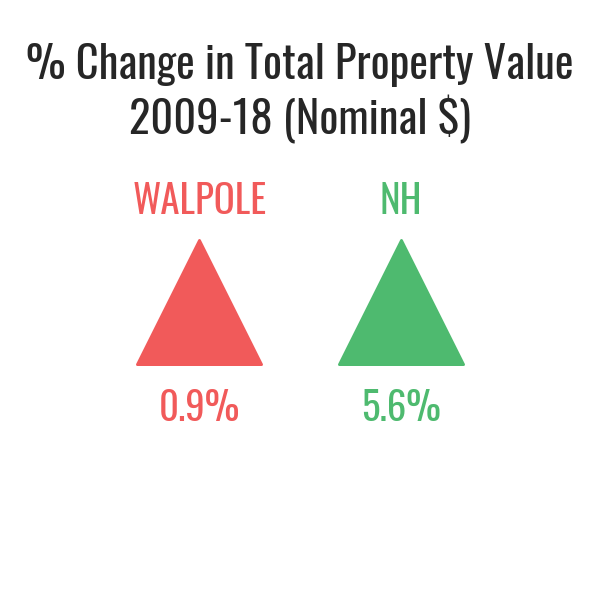

<IPython.core.display.Javascript object>


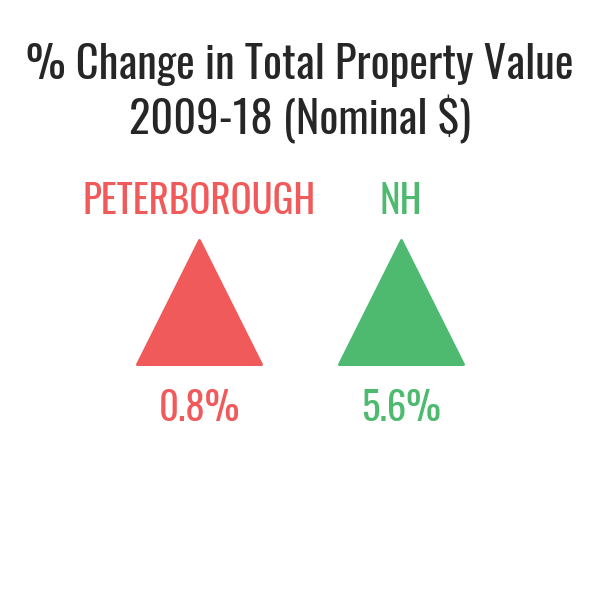

<IPython.core.display.Javascript object>


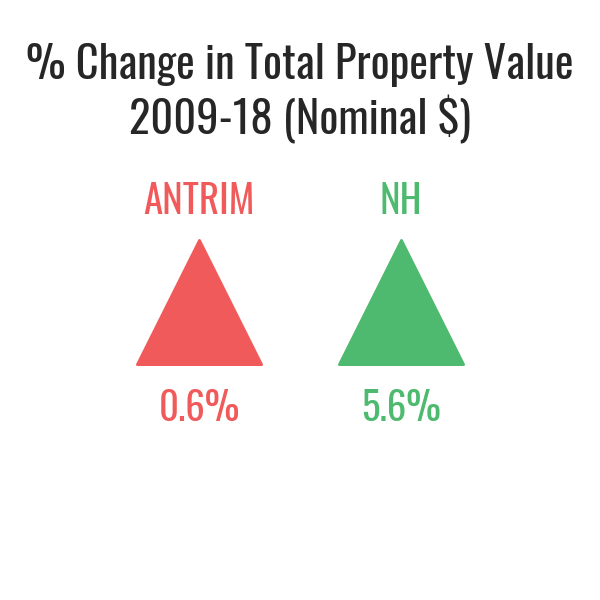

<IPython.core.display.Javascript object>


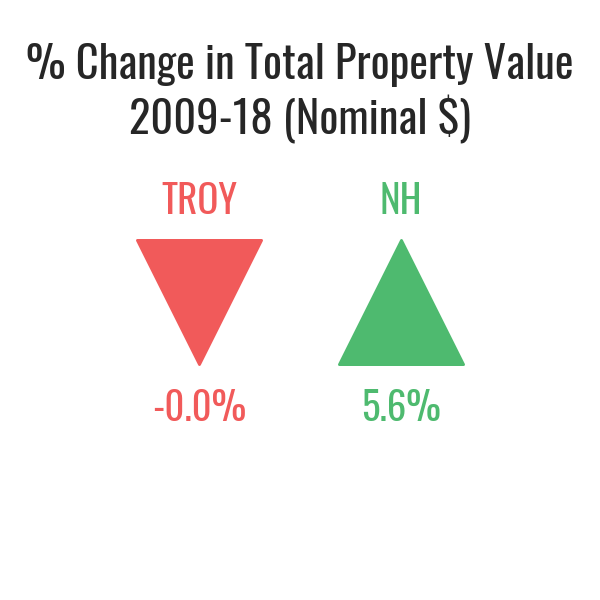

<IPython.core.display.Javascript object>


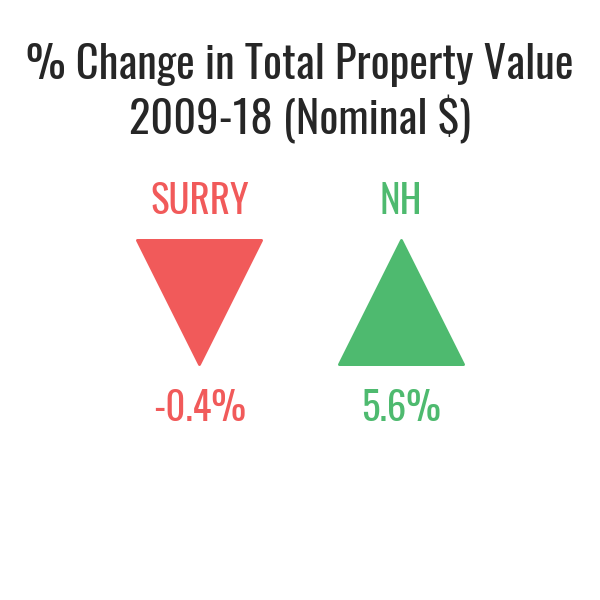

<IPython.core.display.Javascript object>


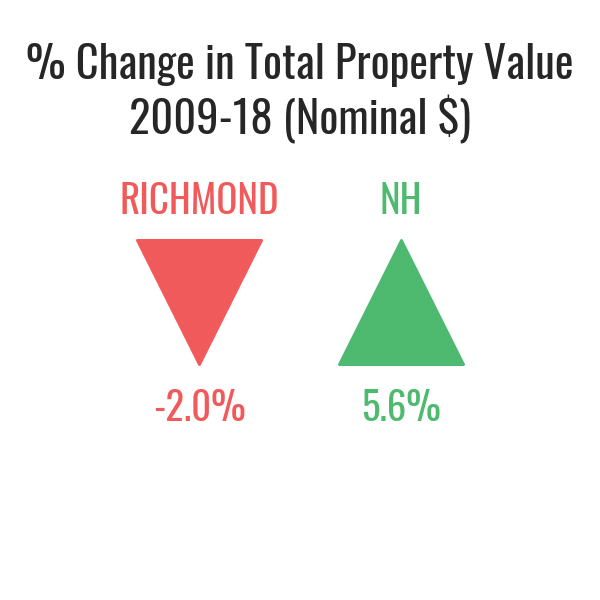

<IPython.core.display.Javascript object>


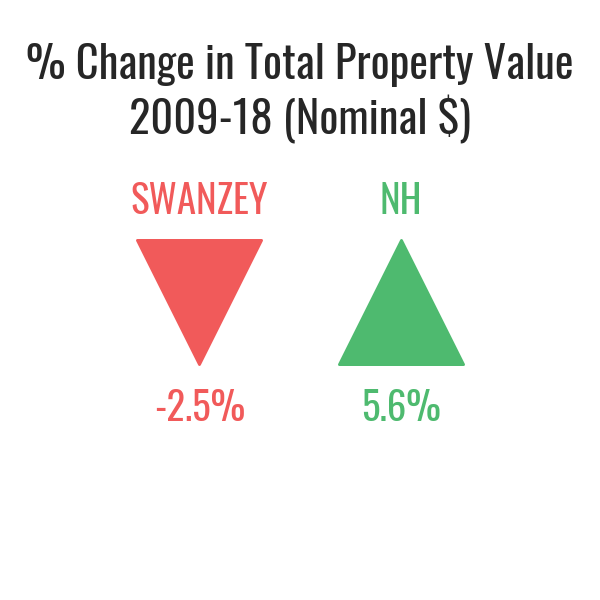

<IPython.core.display.Javascript object>


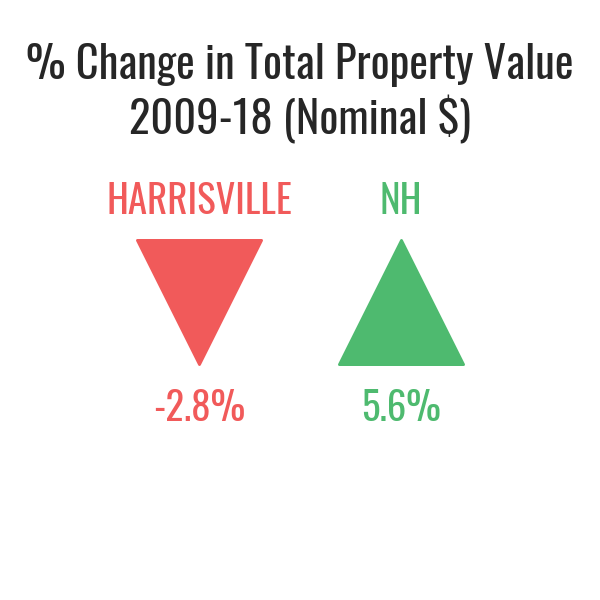

<IPython.core.display.Javascript object>


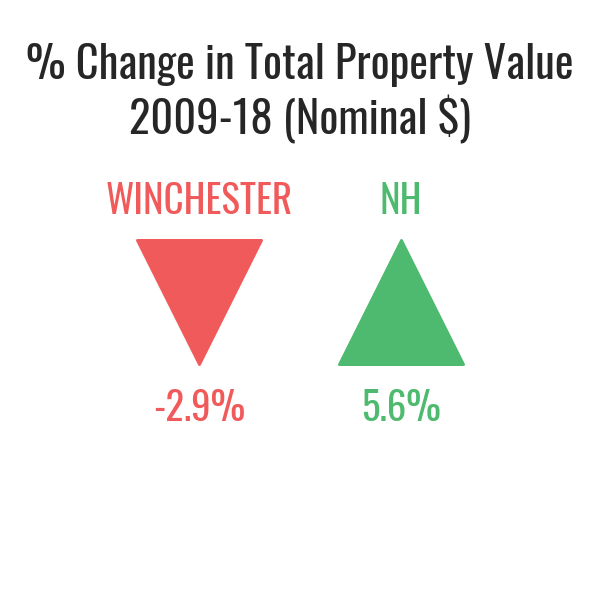

<IPython.core.display.Javascript object>


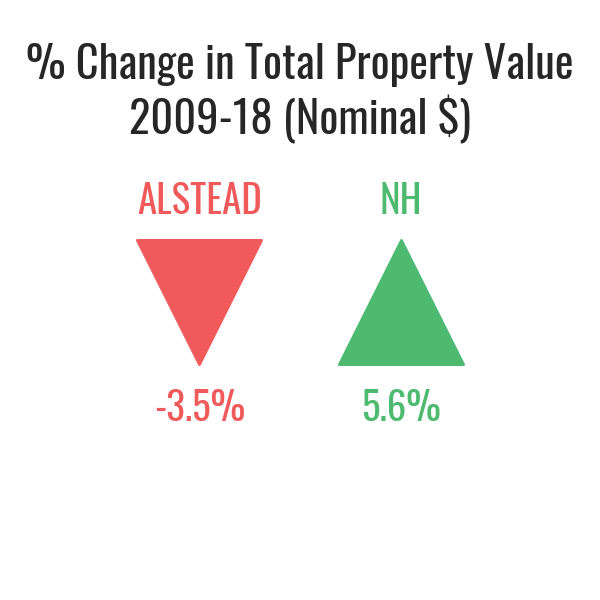

<IPython.core.display.Javascript object>


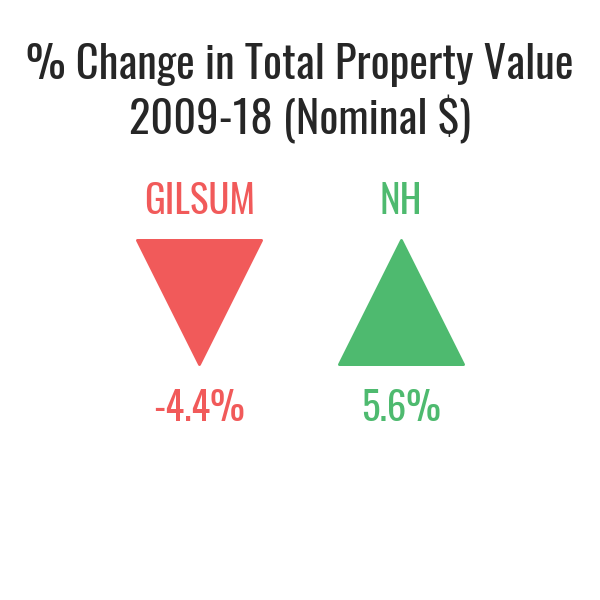

<IPython.core.display.Javascript object>


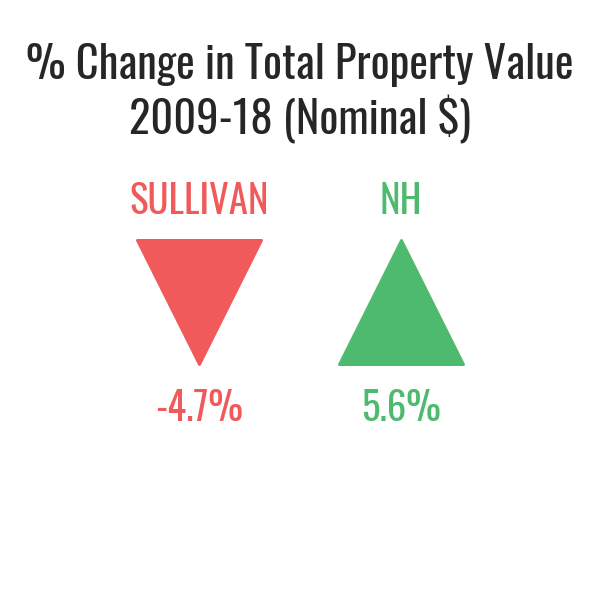

<IPython.core.display.Javascript object>


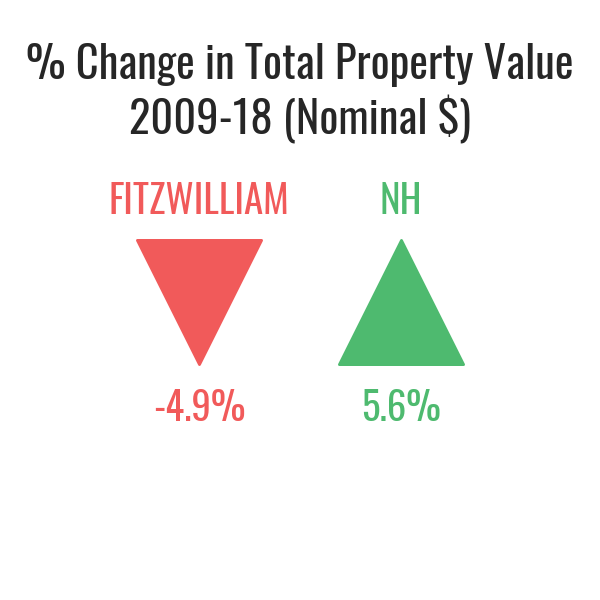

<IPython.core.display.Javascript object>


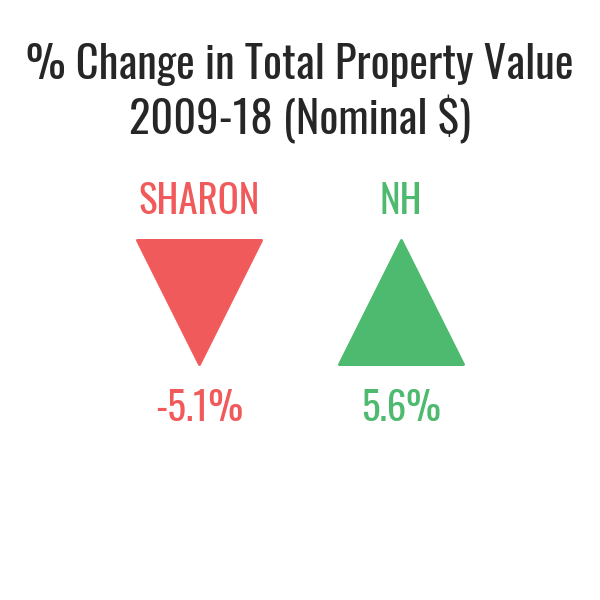

<IPython.core.display.Javascript object>


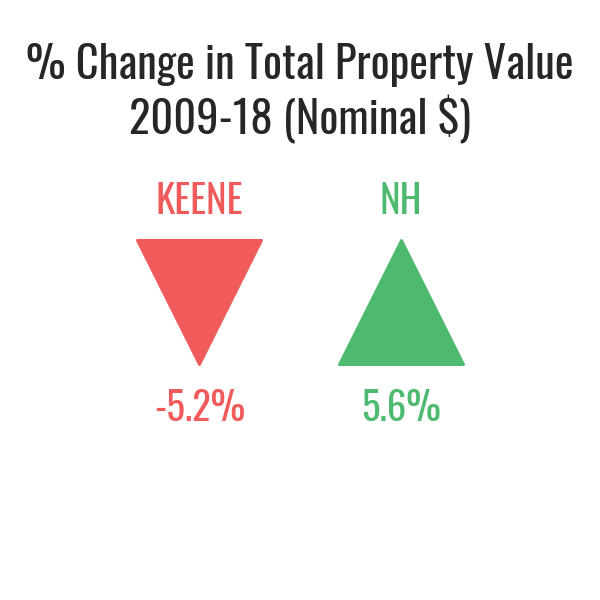

<IPython.core.display.Javascript object>


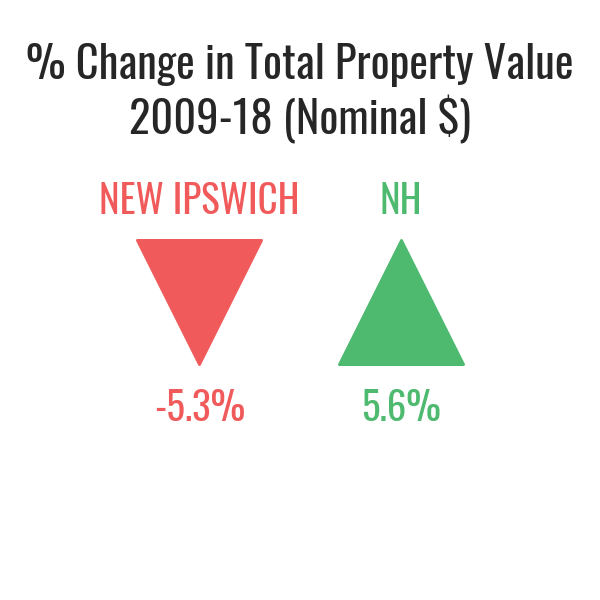

/Users/toddhorner/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


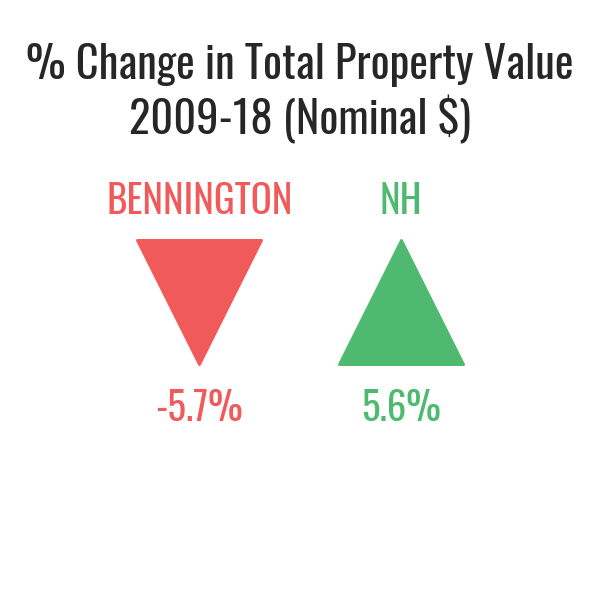

<IPython.core.display.Javascript object>


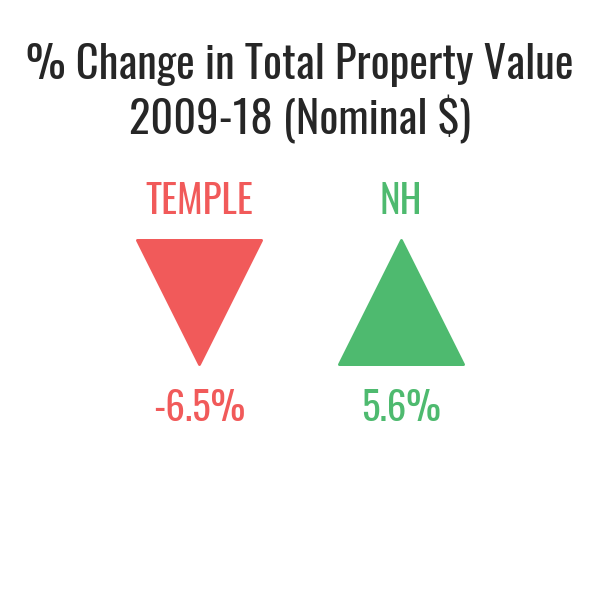

<IPython.core.display.Javascript object>


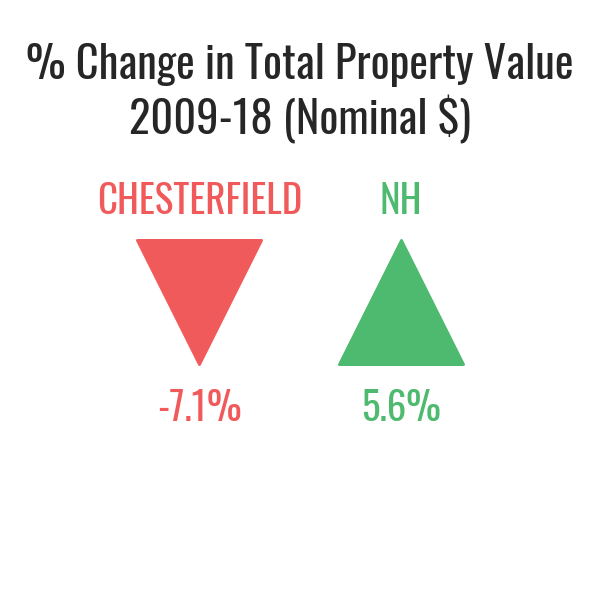

<IPython.core.display.Javascript object>


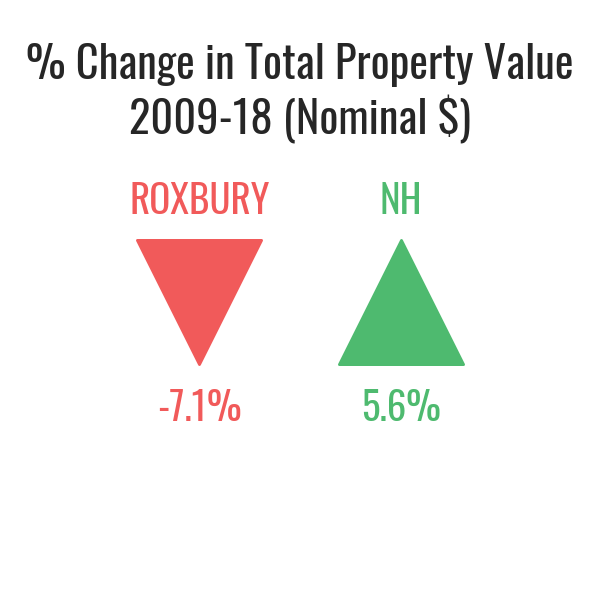

<IPython.core.display.Javascript object>


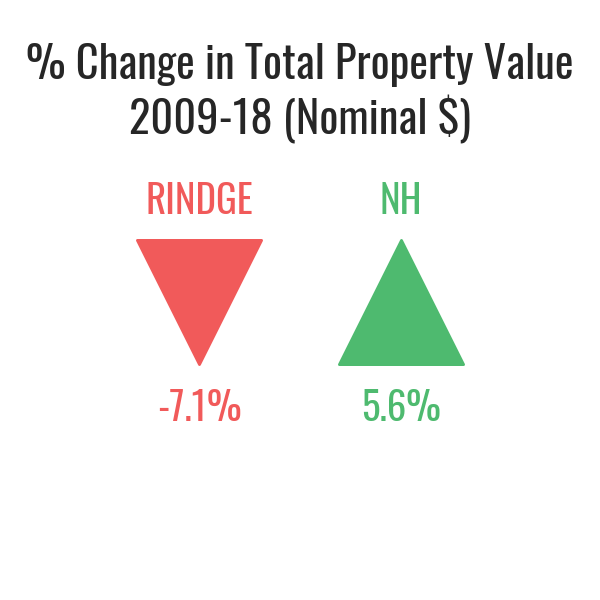

<IPython.core.display.Javascript object>


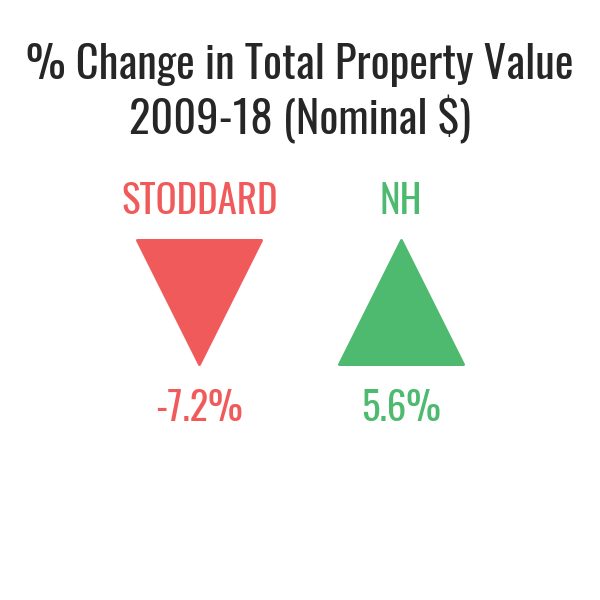

<IPython.core.display.Javascript object>


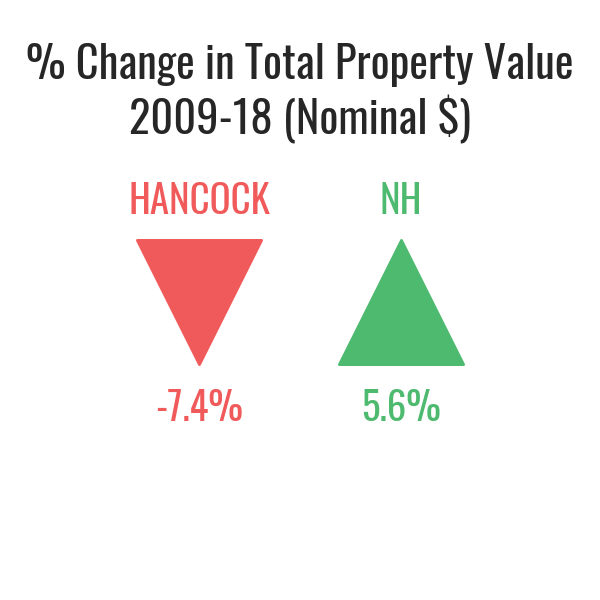

<IPython.core.display.Javascript object>


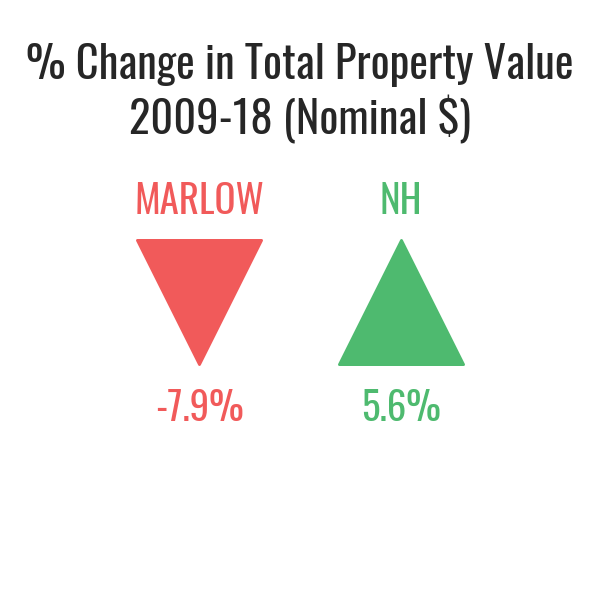

<IPython.core.display.Javascript object>


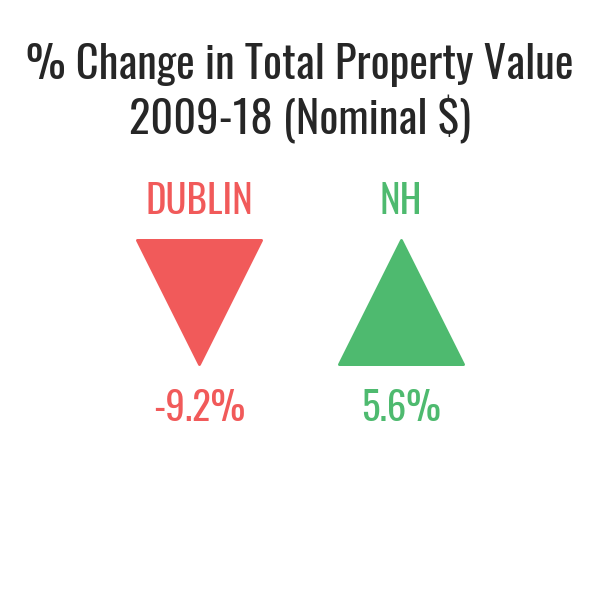

<IPython.core.display.Javascript object>


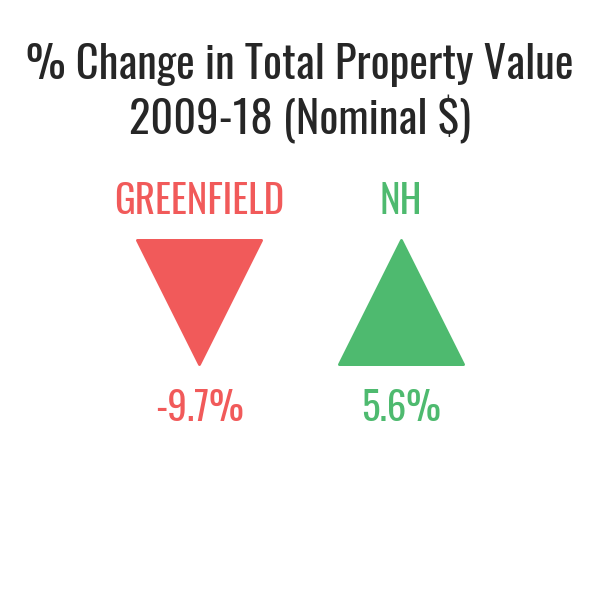

<IPython.core.display.Javascript object>


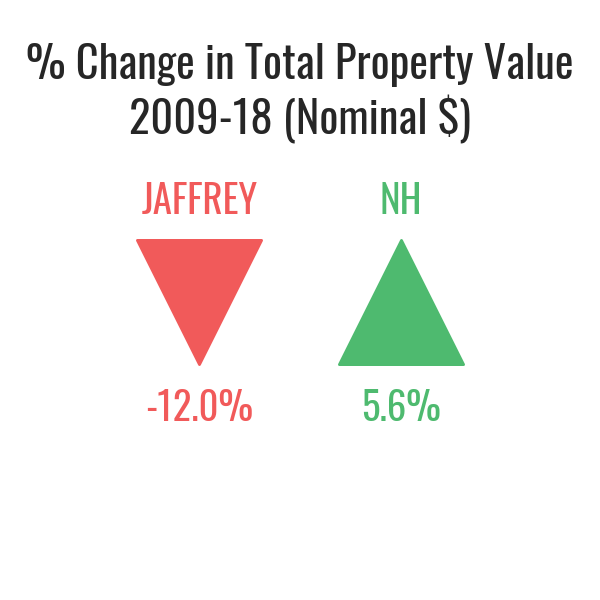

<IPython.core.display.Javascript object>


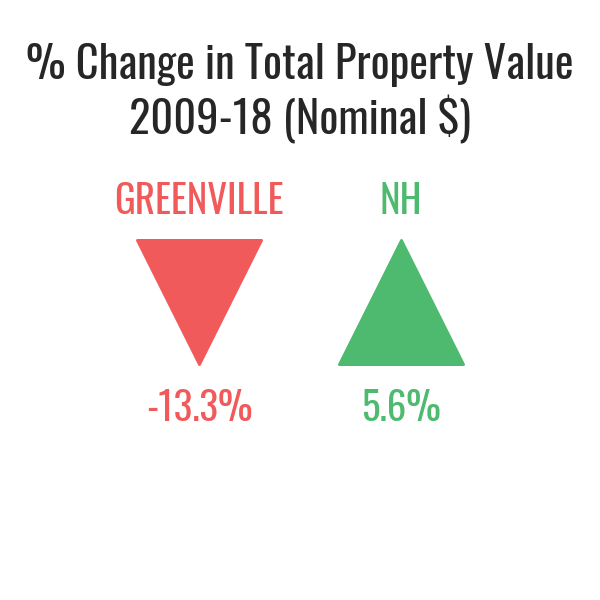

<IPython.core.display.Javascript object>


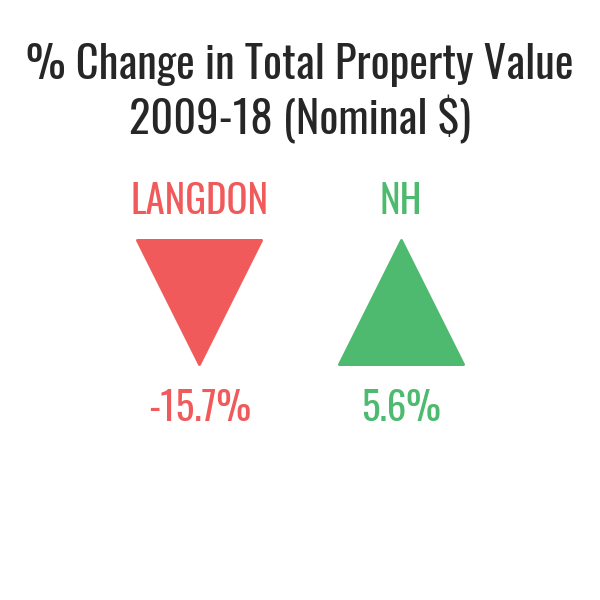

<IPython.core.display.Javascript object>


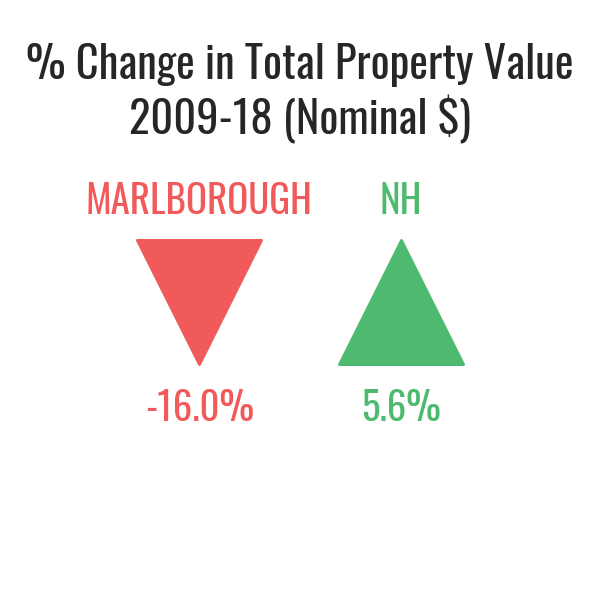

<IPython.core.display.Javascript object>


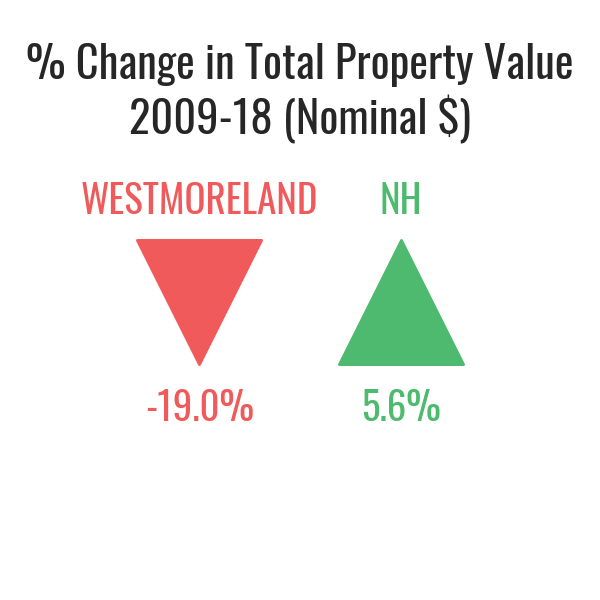

In [246]:
for i in range(1,len(swrpc)):
    d = swrpc.iloc[[0,i]]
    d = d[::-1]
    d = d.reset_index(drop=True)
    graph_df(d)

## Get Census Data

I pulled population data for each town, thinking that I would evaluate assesed property value per capita. Now thinking that either assesesed value per acre is a better measure or simply comparing percent change is the best way to go.

In [ ]:
def try_dropping_cols(df, cols):
    for col in cols:
        try:
            df.drop(col,axis=1,inplace=True)
        except:
            pass

In [ ]:
def parse_census_data(url, yr):
    df = pd.read_json(url,orient='columns')
    df.columns = df.loc[0]
    df = df.drop(0)
    try:
        df = df[df.DATE_DESC.str.contains(yr)]
    except:
        pass
    df['FIPS'] = df.state + df.county + df['county subdivision']
    try_dropping_cols(df, ['DATE_DESC','county','DATE_','state','county','county subdivision'])
    df = df.merge(swrpc,how='right',left_on='FIPS',right_on='FIPS')
    df = df.drop(['GEONAME','TOWN_UPPER'],axis=1)
    df = df[['TOWN','FIPS','POP']]
    df = df.rename(columns={'POP':'POP_{}'.format(yr[2:])})
    return df

pop09_url = 'https://api.census.gov/data/2000/pep/int_population?get=GEONAME,POP,DATE_DESC&for=county%20subdivision:*&in=state:33&DATE_=2&DATE_=11&key=deafea3f81e115c236f1ae6fe3eeb07b7a4a6197'
pop_09 = parse_census_data(pop09_url, '2009')

In [ ]:
pop18_url = 'https://api.census.gov/data/2018/pep/population?get=GEONAME,POP&for=county%20subdivision:*&in=state:33%20county:*&key=deafea3f81e115c236f1ae6fe3eeb07b7a4a6197'
pop_18 = parse_census_data(pop18_url,'2018')

In [ ]:
pop = pop_09.merge(pop_18)
pop

## Get Area Data

In [ ]:
dbf = Dbf5('../../Data/Property Tax/tl_2018_33_cousub.dbf')
geos = dbf.to_dataframe()
geos = geos.merge(swrpc,how='right',left_on='GEOID',right_on='FIPS')
geos = geos[['NAME','FIPS','ALAND']]

In [ ]:
geos['ACRES'] = geos['ALAND'] / 4046.86

## Combine valuation and land area data

In [ ]:
df = df.merge(geos)

In [ ]:
df = df[['TOWN','FIPS','VAL_2009','VAL_2018','ACRES']]

In [ ]:
df['VALACRE_09'] = df['VAL_2009'] / df['ACRES']
df['VALACRE_18'] = df['VAL_2018'] / df['ACRES']

In [ ]:
df['PCT_CHANGE_VALACRE'] = df['VALACRE_18'] / df['VALACRE_09'] - 1

In [ ]:
df[['TOWN','PCT_CHANGE_VALACRE']].sort_values(by='PCT_CHANGE_VALACRE')

In [ ]:
100599352/120065289 - 1